### Experiment1_LeedsDataset_Fulltasks
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Studying the feature vectors in the feature space

In [1]:
import os
from six.moves import xrange  # pylint: disable=redefined-builtin
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage import io

# Custom scripts
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [2]:
height=112 
width=112 
channel=3
crop_size=112

cluster_length=16
feature_size=8192 #4608 #   #16384  #487
nb_classes=2
saved_path='/nobackup/leopauly/S2l/'

batch_size=32
memory_batch_size_train=266
memory_batch_size_test=170
next_batch_start=0
sample_batch_size=10

####  Loading model and functions for calculating distance

In [3]:
## Defining placeholders in tf for images and targets
x_image = tf.placeholder(tf.float32, [None, 16,height,width,channel],name='x') 
y_true = tf.placeholder(tf.float32, [None, nb_classes],name='y_true')
y_true_cls = tf.placeholder(tf.int64, [None],name='y_true_cls')

model_keras = md.C3D_ucf101_training_model_tf(summary=True)
out=model_keras(x_image)
y_pred = tf.nn.softmax(out)
y_pred_cls = tf.argmax(out, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('Miscellenious items finished..!!',flush=True)

/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:281: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", name="conv1", input_shape=(16, 112, ..., padding="same")`
  input_shape=input_shape))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:283: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid")`
  border_mode='valid', name='pool1'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:286: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", padding="same")`
  border_mode='same', name='conv2'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:288: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_si

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0         
__________

In [4]:
def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    cos_val=dotproduct(v1, v2) / (length(v1) * length(v2))
    cos_val=float(cos_val)
    cos_val=clean_cos(cos_val)
    angle_in_rad=math.acos(cos_val)
    #print(angle_in_rad)
    return angle_in_rad

def clean_cos(cos_val):
    return min(1,max(cos_val,-1))

In [5]:
def get_compress_frames_data(filename, num_frames_per_clip=16):
  ''' Given a directory containing extracted frames, return a video clip of
  (num_frames_per_clip) consecutive frames as a list of np arrays '''
  ret_arr = []
  for parent, dirnames, filenames in os.walk(filename):

    filenames = sorted(filenames)
    jump=math.floor((len(filenames)/num_frames_per_clip))
    loop=0
    for i in range(0,len(filenames),jump):
      if (loop>15):
        break
      if (filenames[i].endswith('.png')):
        print(str(filename) + '/' + str(filenames[i]))
        image_name = str(filename) + '/' + str(filenames[i])
        img = Image.open(image_name)
        img_data = np.array(img)
        ret_arr.append(img_data)
        loop=loop+1
  ret_arr=np.array(ret_arr)
  #ret_arr=ret_arr/255
  return np.array(ret_arr)

In [6]:
## Extraction of features 
def extract_video_features(vid):
    vid_=vid.reshape(-1,cluster_length,height,width,channel)
    #f_v = sess.graph.get_tensor_by_name('dropout_2/cond/Merge:0')  #('flatten_1/Reshape:0')
    f_v_val=sess.run([y_pred], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })
    features=np.reshape(f_v_val,(-1))
    return features

In [7]:
def dist_angle_calc(directory1,directory2):
    baseline_dist=[]
    baseline_angle=[]
    activity_dist=[]
    activitynet_angle=[]
    
    subfolders1=os.listdir(directory1)
    subfolders1=sorted(subfolders1)
    subfolders2=os.listdir(directory2)
    subfolders2=sorted(subfolders2)
    
    for subfolder1_ in subfolders1:
        data1=get_compress_frames_data(directory1+'/'+subfolder1_)
        
        for subfolder2_ in subfolders2:
            data2=get_compress_frames_data(directory2+'/'+subfolder2_)
            
            dist_base_=np.linalg.norm(extract_baseline_video_features(data1)-extract_baseline_video_features(data2))
            
            baseline_dist.append(dist_base_)
            
            angle_base_=angle(extract_baseline_video_features(data1),extract_baseline_video_features(data2))
            
            baseline_angle.append(angle_base_)
    
    return baseline_dist,baseline_angle

####  Feature extraction and Plotting

In [8]:
## Start the session with logging placement.
init_op = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
sess.run(init_op)

## Restore model weights from previously saved model
saver = tf.train.Saver()
saver.restore(sess, os.path.join(saved_path,'activity_model.ckpt-67'))
print("Model restored from file: %s" % saved_path,flush=True)

INFO:tensorflow:Restoring parameters from /nobackup/leopauly/S2l/activity_model.ckpt-67
Model restored from file: /nobackup/leopauly/S2l/


In [9]:
dist_sim_class1=[]
dist_sim_class2=[]
dist_dif=[]

['.DS_Store', 'push_human_V1', 'push_human_V2', 'push_org_green_V1', 'push_org_green_V2', 'push_sim_green_V1', 'push_sim_green_V90']
['.DS_Store', 'push_human_V1', 'push_human_V2', 'push_org_green_V1', 'push_org_green_V2', 'push_sim_green_V1', 'push_sim_green_V90']
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/008.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/016.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/024.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/032.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/040.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/048.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/056.png
/nobackup/leop

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V90/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V90/061.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V90/122.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V90/183.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V90/244.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V90/305.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V90/366.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V90/427.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V90/489.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V90/550.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V1/060.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V1/120.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V1/180.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V1/240.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V1/300.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V1/360.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V1/420.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V1/480.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_sim_green_V1/540.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Fram

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V2/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V2/016.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V2/032.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V2/048.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V2/064.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V2/080.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V2/096.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V2/112.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V2/128.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V2/144.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Fram

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V1/016.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V1/032.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V1/048.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V1/064.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V1/080.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V1/096.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V1/112.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V1/128.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_org_green_V1/144.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Fram

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/008.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/016.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/024.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/032.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/040.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/048.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/056.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/064.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/072.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/080.png
/nobackup/

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/008.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/016.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/024.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/032.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/040.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/048.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/056.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/064.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/072.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V2/080.png
/nobackup/

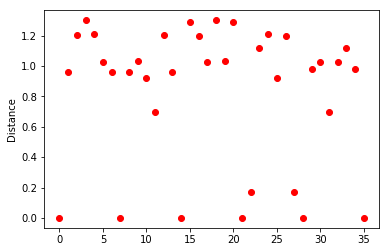

In [10]:
## Calculating distance
base_dir_a='/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/'
sub_dir_a=os.listdir(base_dir_a)
sub_dir_a=sorted(sub_dir_a)
print(sub_dir_a)
if '.DS_Store' in sub_dir_a:
    sub_dir_a.remove('.DS_Store')

base_dir_b='/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/'
sub_dir_b=os.listdir(base_dir_b)
sub_dir_b=sorted(sub_dir_b)
print(sub_dir_b)
if '.DS_Store' in sub_dir_b:
    sub_dir_b.remove('.DS_Store')

for sub_dir_a_ in sub_dir_a:
        
        vid_a=get_compress_frames_data(base_dir_a+sub_dir_a_)
        
        for sub_dir_b_ in sub_dir_b:
            vid_b=get_compress_frames_data(base_dir_b+sub_dir_b_)
            feature_dist=np.linalg.norm(extract_video_features(vid_a)-extract_video_features(vid_b))
            dist_sim_class1.append(feature_dist)

## Calculating intra-class variance
dist_sim_class1_nozero=[x for x in dist_sim_class1 if x!=0]
intra_var_class1=sum(dist_sim_class1_nozero)/len(dist_sim_class1_nozero)
print('Inter class variance bw class 1 :',intra_var_class1)



## Plotting
plt.plot(dist_sim_class1,'ro')
plt.ylabel('Distance')
plt.show()

['.DS_Store', 'reach_human_V1', 'reach_human_V2', 'reach_org_V1', 'reach_org_V90', 'reach_sim_brown_V1', 'reach_sim_green_V1']
['.DS_Store', 'reach_human_V1', 'reach_human_V2', 'reach_org_V1', 'reach_org_V90', 'reach_sim_brown_V1', 'reach_sim_green_V1']
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/005.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/010.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/015.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/020.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/025.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/030.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/035.png
/nobackup/

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/023.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/046.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/069.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/092.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/115.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/138.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/161.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/184.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/207.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dat

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/028.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/056.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/084.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/112.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/140.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/168.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/196.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/224.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/252.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dat

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/009.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/018.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/027.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/036.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/045.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/054.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/063.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/072.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/081.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/090.png

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/030.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/060.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/090.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/120.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/150.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/180.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/210.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/240.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/270.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/300.png
/nobackup/

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/005.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/010.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/015.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/020.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/025.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/030.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/035.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/040.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/045.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/005.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/010.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/015.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/020.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/025.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/030.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/035.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/040.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/045.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human

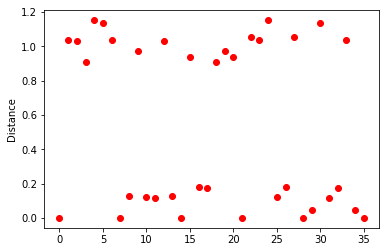

In [11]:
## Calculating distance
base_dir_a='/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/'
sub_dir_a=os.listdir(base_dir_a)
sub_dir_a=sorted(sub_dir_a)
print(sub_dir_a)
if '.DS_Store' in sub_dir_a:
    sub_dir_a.remove('.DS_Store')

base_dir_b='/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/'
sub_dir_b=os.listdir(base_dir_b)
sub_dir_b=sorted(sub_dir_b)
print(sub_dir_b)
if '.DS_Store' in sub_dir_b:
    sub_dir_b.remove('.DS_Store')

for sub_dir_a_ in sub_dir_a:
        
        vid_a=get_compress_frames_data(base_dir_a+sub_dir_a_)
        
        for sub_dir_b_ in sub_dir_b:
            vid_b=get_compress_frames_data(base_dir_b+sub_dir_b_)
            feature_dist=np.linalg.norm(extract_video_features(vid_a)-extract_video_features(vid_b))
            dist_sim_class2.append(feature_dist)

## Calculating intra-class variance
dist_sim_class2_nozero=[x for x in dist_sim_class2 if x!=0]
intra_var_class2=sum(dist_sim_class2_nozero)/len(dist_sim_class2_nozero)
print('Inter class variance bw class 2:',intra_var_class2)

## Plotting
plt.plot(dist_sim_class2,'ro')
plt.ylabel('Distance')
plt.show()

['.DS_Store', 'push_human_V1', 'push_human_V2', 'push_org_green_V1', 'push_org_green_V2', 'push_sim_green_V1', 'push_sim_green_V90']
['.DS_Store', 'reach_human_V1', 'reach_human_V2', 'reach_org_V1', 'reach_org_V90', 'reach_sim_brown_V1', 'reach_sim_green_V1']
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/008.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/016.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/024.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/032.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/040.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/048.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/056.png
/nobackup/leopauly/S

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/023.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/046.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/069.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/092.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/115.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/138.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/161.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/184.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_green_V1/207.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dat

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/028.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/056.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/084.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/112.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/140.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/168.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/196.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/224.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_sim_brown_V1/252.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dat

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/009.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/018.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/027.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/036.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/045.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/054.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/063.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/072.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/081.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V90/090.png

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/030.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/060.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/090.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/120.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/150.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/180.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/210.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/240.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/270.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_org_V1/300.png
/nobackup/

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/005.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/010.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/015.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/020.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/025.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/030.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/035.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/040.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/045.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/005.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/010.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/015.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/020.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/025.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/030.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/035.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/040.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V2/045.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human

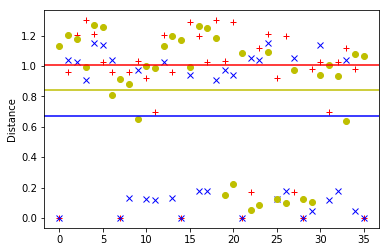

In [12]:
## Calculating distance
base_dir_a='/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/'
sub_dir_a=os.listdir(base_dir_a)
sub_dir_a=sorted(sub_dir_a)
print(sub_dir_a)
if '.DS_Store' in sub_dir_a:
    sub_dir_a.remove('.DS_Store')

base_dir_b='/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/'
sub_dir_b=os.listdir(base_dir_b)
sub_dir_b=sorted(sub_dir_b)
print(sub_dir_b)
if '.DS_Store' in sub_dir_b:
    sub_dir_b.remove('.DS_Store')

for sub_dir_a_ in sub_dir_a:
        
        vid_a=get_compress_frames_data(base_dir_a+sub_dir_a_)
        
        for sub_dir_b_ in sub_dir_b:
            vid_b=get_compress_frames_data(base_dir_b+sub_dir_b_)
            feature_dist=np.linalg.norm(extract_video_features(vid_a)-extract_video_features(vid_b))
            dist_dif.append(feature_dist)


## Calculating inter-class variance
inter_var=sum(dist_dif)/len(dist_dif)
print('Inter class variance bw class 1 and class 2:',inter_var)

## Plotting
plt.plot(dist_sim_class1,'+',color='r')
plt.plot(dist_sim_class2,'x',color='b')
plt.plot(dist_dif,'ro',color='y')
plt.axhline(intra_var_class1,color='r')
plt.axhline(intra_var_class2,color='b')
plt.axhline(inter_var,color='y')
plt.ylabel('Distance')
plt.show()

In [13]:
feature_set_a=[]
feature_set_b=[]

In [14]:
## Calculating Features
base_dir_a='/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/'
sub_dir_a=os.listdir(base_dir_a)
sub_dir_a=sorted(sub_dir_a)
print(sub_dir_a)
if '.DS_Store' in sub_dir_a:
    sub_dir_a.remove('.DS_Store')

base_dir_b='/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/'
sub_dir_b=os.listdir(base_dir_b)
sub_dir_b=sorted(sub_dir_b)
print(sub_dir_b)
if '.DS_Store' in sub_dir_b:
    sub_dir_b.remove('.DS_Store')

for sub_dir_a_ in sub_dir_a:  
        vid_a=get_compress_frames_data(base_dir_a+sub_dir_a_)
        feature_set_a.append(extract_video_features(vid_a))
        

for sub_dir_b_ in sub_dir_b:  
        vid_a=get_compress_frames_data(base_dir_b+sub_dir_b_)
        feature_set_b.append(extract_video_features(vid_b))

['.DS_Store', 'push_human_V1', 'push_human_V2', 'push_org_green_V1', 'push_org_green_V2', 'push_sim_green_V1', 'push_sim_green_V90']
['.DS_Store', 'reach_human_V1', 'reach_human_V2', 'reach_org_V1', 'reach_org_V90', 'reach_sim_brown_V1', 'reach_sim_green_V1']
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/008.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/016.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/024.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/032.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/040.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/048.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Push/push_human_V1/056.png
/nobackup/leopauly/S

/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/000.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/005.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/010.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/015.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/020.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/025.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/030.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/035.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/040.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human_V1/045.png
/nobackup/leopauly/S2l/Dataset/Leeds_Dataset_Full_Tasks/Frames/Reach/reach_human

In [15]:
## TSNE compression
tsne_obj = TSNE(n_components=3, verbose=1)

vis_tsne_a=tsne_obj.fit_transform(feature_set_a) 
vis_tsne_a=np.array(vis_tsne_a)

vis_tsne_b=tsne_obj.fit_transform(feature_set_b) 
vis_tsne_b=np.array(vis_tsne_b)

print(vis_tsne_a.shape)
print(vis_tsne_b.shape)
print(vis_tsne_a)
print(vis_tsne_b)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: 1.039666
[t-SNE] Error after 75 iterations: 1.039666
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 50 iterations with early exaggeration: -3.501325
[t-SNE] Error after 75 iterations: -3.501325
(6, 3)
(6, 3)
[[ -2.48357124e-04   1.10829513e-04   2.21666611e-05]
 [ -1.47518108e-04  -5.17641741e-06   8.36387710e-05]
 [  5.98424387e-05  -6.59365175e-06   7.13128896e-05]
 [  8.49510301e-05   1.08590147e-04   8.58055440e-06]
 [  3.26908601e-05   3.89358609e-05  -1.25801789e-05]
 [ -1.07560402e-05   9.13974168e-05   1.64569439e-04]]
[[-120.77816815  306.64911715   76.87199163]
 [-1

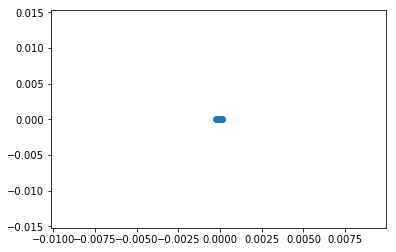

In [16]:
## Plotting
plt.scatter(vis_tsne_a[:, 0], vis_tsne_a[:, 1])
#plt.scatter(vis_tsne_b[:, 0], vis_tsne_b[:, 1])
plt.show()